In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import sys
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from matplotlib import pyplot as plt
import torch.optim as optim
sys.path.insert(0, '/home/dpakhom1/projects/pytorch_pascal_vgg/pytorch-image-segmentation/')
from pytorch_image_segmentation.datasets import pascal_voc as pascal
from pytorch_image_segmentation.models.fcn_32s import FCN32s
from torch.utils.data import DataLoader
from pytorch_image_segmentation.transforms import (ComposeJoint,RandomHorizontalFlipJoint,RandomScaleJoint)
from sklearn.metrics import confusion_matrix

PATH = '/home/dpakhom1/projects/pytorch_pascal_vgg/pytorch-image-segmentation/pytorch_image_segmentation/recipes/'

net = FCN32s(num_classes=21).cuda()

net.load_state_dict(torch.load(PATH + 'fcn_32sRS_best'))

def get_flat_labels(labels):
    return labels.view(-1)

def get_val_index(flat_labels, mask=255):
    return torch.squeeze(torch.nonzero((flat_labels != mask)), 1)

transform = ComposeJoint([
    RandomHorizontalFlipJoint(),
    [transforms.ToTensor(),None],
    [transforms.Normalize(mean = (0.485, 0.456, 0.406),std = (0.229, 0.224, 0.225)),None],
    [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long())]
                        ])

train_dataset = pascal.PascalVOCSegmentation(download=False, joint_transform=transform)
val_dataset = pascal.PascalVOCSegmentation(download=False, joint_transform=transform,train=False)
train_subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(xrange(200))
train_subset_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                  sampler=train_subset_sampler, num_workers=2)


train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=False, num_workers=2)


net.train()
optimizer = optim.Adam(net.parameters(),lr = 0.000001,weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

In [2]:
print(net.model.named_parameters)

<bound method VGG.named_parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

<IPython.core.display.Javascript object>


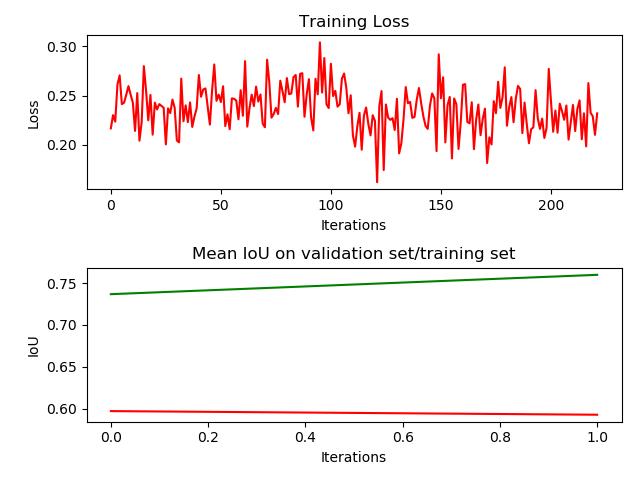

In [2]:
%matplotlib notebook

loss_history = []
loss_iter_history = []
loss_curr_iter = 0

val_history = []
val_iter_history = []
val_iter_curr = 0

IoU_history = []
IoU_iter_history = []
IoU_curr_iter = 0

f, (loss_axis, val_axis) = plt.subplots(2,1)

loss_axis.plot(loss_history, loss_iter_history, 'r')
loss_axis.set(ylabel = 'Loss', xlabel='Iterations', title='Training Loss')

val_axis.set(xlabel='Iterations', ylabel='IoU', title='Mean IoU on validation set/training set')
val_axis.plot(val_iter_history, val_history, 'r', IoU_iter_history, IoU_history, 'g')

plt.tight_layout()


In [4]:
print(torch.__version__)

0.4.1


In [3]:
best_val_acc = 0

for epoch in range(2):
    
    net.train()
    
    sum_loss = 0
    
    for idx, data in enumerate(train_dataloader, 0):
        
        
        inputs, labels = Variable(data[0]).cuda(), Variable(data[1]).cuda()       

        
        optimizer.zero_grad()
        labels = get_flat_labels(labels)
        index = get_val_index(labels)
        labels = torch.index_select(labels, 0, index)
        output = net(inputs)
        output = output.squeeze()
        output = output.permute(1, 2, 0)
        output = output.contiguous()
        output = output.view(output.shape[0] * output.shape[1],-1)
        output = torch.index_select(output, 0, index)
        
        loss = criterion(output,labels)
        
        sum_loss += loss.item()
        
        if idx % 100 == 99:
            
            loss_history.append(sum_loss / 100)
            print(idx + 1, sum_loss / 100)
            loss_iter_history.append(loss_curr_iter)
            
            loss_curr_iter += 1
            
            loss_axis.lines[0].set_xdata(loss_iter_history)
            loss_axis.lines[0].set_ydata(loss_history)

            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
            
            sum_loss = 0
        

        loss.backward()
        optimizer.step()
        #print(idx+1, loss.item())
    
    net.eval()
    
    IoU_matrix = np.zeros((net.num_classes, net.num_classes))
    
    for idx, data in enumerate(train_subset_loader, 0):
        
        inputs, labels = Variable(data[0]).cuda(), Variable(data[1]).cuda()
        output = net(inputs)
        _, output = torch.max(output.data, dim=1)
        output = output.cpu().numpy().flatten()
        labels = labels.cpu().data.numpy().flatten()
            
        IoU_matrix += confusion_matrix(output, labels, labels = [i for i in range(net.num_classes)])
            
    true_positives = (np.diag(IoU_matrix))
    false_negatives = np.sum(IoU_matrix, axis=1) - true_positives
    false_positives = np.sum(IoU_matrix, axis=0) - true_positives
        
    IoU_value = np.sum((true_positives/(true_positives + false_negatives + false_positives))) / 21
        
    IoU_history.append(IoU_value)
    IoU_iter_history.append(IoU_curr_iter)
    IoU_curr_iter += 1
        
    val_axis.lines[1].set_xdata(IoU_iter_history)
    val_axis.lines[1].set_ydata(IoU_history)
        
    val_axis.relim()
    val_axis.autoscale_view()
    val_axis.figure.canvas.draw()
    
    IoU_matrix = np.zeros((net.num_classes, net.num_classes))
    
    for idx, data in enumerate(val_dataloader, 0):
        
        inputs, labels = Variable(data[0]).cuda(), Variable(data[1]).cuda()
        
        output = net(inputs)
        _, output = torch.max(output.data, dim=1)
        output = output.cpu().numpy().flatten()
        labels = labels.cpu().data.numpy().flatten()
            
        IoU_matrix += confusion_matrix(output, labels, labels = [i for i in range(net.num_classes)])
        
    true_positives = (np.diag(IoU_matrix))
    false_negatives = np.sum(IoU_matrix, axis=1) - true_positives
    false_positives = np.sum(IoU_matrix, axis=0) - true_positives
        
    IoU_value = np.sum((true_positives/(true_positives + false_negatives + false_positives))) / 21
        
    val_history.append(IoU_value)
    val_iter_history.append(val_iter_curr)
    val_iter_curr += 1
        
    val_axis.lines[0].set_xdata(val_iter_history)
    val_axis.lines[0].set_ydata(val_history)
        
    val_axis.relim()
    val_axis.autoscale_view()
    val_axis.figure.canvas.draw()
    
    print(IoU_value)
    
    if IoU_value > best_val_acc:
            
        best_val_acc = IoU_value
        torch.save(net.state_dict(), PATH + 'fcn_32sRS_best')

print('Finished training')
print('Best validation accuracy: ', best_val_acc)

/home/dpakhom1/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


(100, 0.2168424370698631)
(200, 0.23024535886012018)
(300, 0.2236413204111159)
(400, 0.26128019399940966)
(500, 0.270443290323019)
(600, 0.2413779880758375)
(700, 0.24283779685385526)
(800, 0.25084362758323553)
(900, 0.2596042823512107)
(1000, 0.25091999422758815)
(1100, 0.24288055339828132)
(1200, 0.2142491206061095)
(1300, 0.2525789200817235)
(1400, 0.20436616075225175)
(1500, 0.22290387975983322)
(1600, 0.2798831482231617)
(1700, 0.2552278196904808)
(1800, 0.22502488924190403)
(1900, 0.2507061083707958)
(2000, 0.21045988261699677)
(2100, 0.2429122238792479)
(2200, 0.23601421148516238)
(2300, 0.2414280341286212)
(2400, 0.23965254384092988)
(2500, 0.23776598365977406)
(2600, 0.2006387216039002)
(2700, 0.23712029922753572)
(2800, 0.2323119472246617)
(2900, 0.2459492928069085)
(3000, 0.23763149185106158)
(3100, 0.20459638571366667)
(3200, 0.2026843603607267)
(3300, 0.2672413178347051)
(3400, 0.22401237501762808)
(3500, 0.24013534660451114)
(3600, 0.22318281488493086)
(3700, 0.2431246409

In [4]:
torch.save(net.state_dict(), PATH + 'fcn_32sRS_best')